In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
path = '../data/raw/Датасет3_Дтп.xlsx'
dataset_name = path.split('/')[-1][:-5]

df = pd.read_excel(path, index_col='Время регистрации', parse_dates=True)
df = df[(df['Широта']!=0) & (df['Долгота']!=0)]
print(df.shape)
df.head(3)

(21493, 6)


,Категория,Идентификатор Еас адреса,Идентификатор Еас здания,Широта,Долгота,Район
Время регистрации,,,,,,
2019-01-01 01:01:13,ДТП с пострадавшими людьми,NaN,NaN,59.937400,30.282000,Василеостровский
2019-01-01 01:01:49,ДТП с пострадавшими людьми,NaN,197864.0,59.936924,30.282853,Василеостровский
2019-01-01 01:01:53,ДТП с пострадавшими людьми,NaN,93814.0,59.946515,30.271703,Василеостровский


In [3]:
df.describe()

,Идентификатор Еас адреса,Идентификатор Еас здания,Широта,Долгота
count,6470.00000,13521.000000,21493.000000,21493.000000
mean,250660.74204,77013.327269,59.920305,30.322673
std,305905.90305,53171.075190,0.147169,0.179949
min,12.00000,6.000000,43.143700,28.324718
25%,42375.00000,35261.000000,59.855621,30.262900
50%,98286.00000,71063.000000,59.926505,30.335184
75%,449148.75000,104783.000000,59.988717,30.406000
max,959234.00000,216955.000000,60.873600,45.898800


(59.7, 60.25)

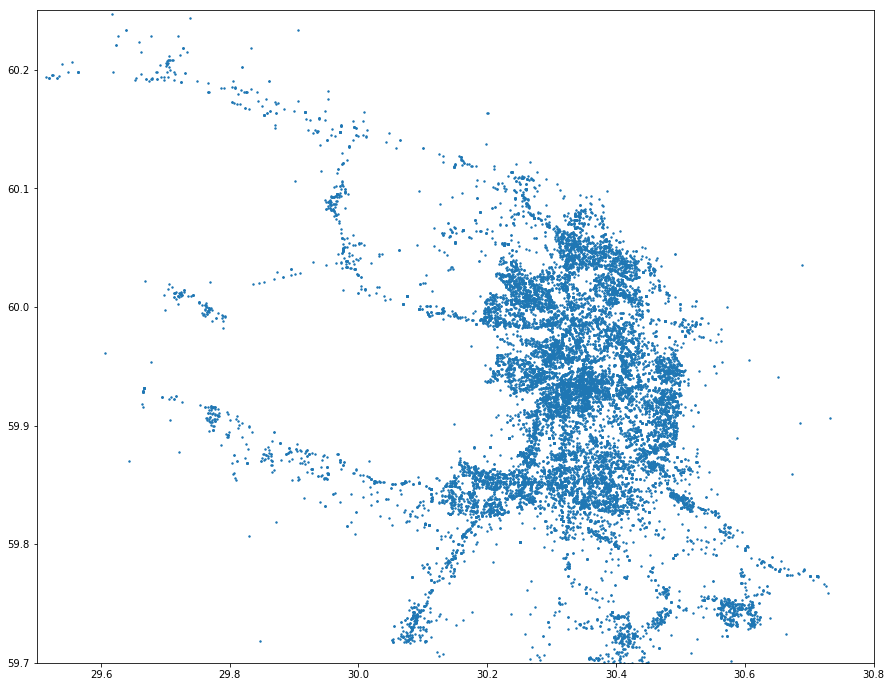

In [4]:
# all events
_ = plt.figure(figsize=(15, 12))
plt.scatter(df['Долгота'], df['Широта'], s=2)
plt.xlim(29.5, 30.8)
plt.ylim(59.7, 60.25)

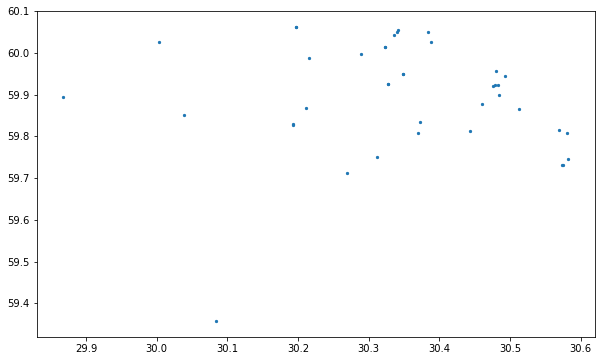

In [5]:
# look at one week events
subdf = df.loc['2020-08-12' : '2020-08-25']
_ = plt.figure(figsize=(10, 6))
plt.scatter(subdf['Долгота'], subdf['Широта'], s=5)
# plt.xlim(29.5, 30.8)
# plt.ylim(59.7, 60.25)

# Look through time

Plot events on map and distribution of distances between points for every time period (day/week/...)

In [6]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import imageio
from tqdm.notebook import tqdm

In [7]:
def plot_for_offset(data, ix):
    # Data for plotting
    
    fig, ax = plt.subplots(figsize=(15,8))
    
    # plot events
    fig.add_subplot(1, 2, 1)
    plt.scatter(subdf['Долгота'], subdf['Широта'], s=2)
    plt.xlim(29.5, 30.8)
    plt.ylim(59.7, 60.25)
    plt.title('Day %d' % ix)
    
    # plot dists distribution
    fig.add_subplot(1, 2, 2)
    dists = []
    coords = list(zip(data['Долгота'].tolist(), data['Широта'].tolist()))
    for i in range(len(coords)):
        for j in range(len(coords)):
            if j > i:
                (x1, y1), (x2, y2) = coords[i], coords[j]
                dist = ((x1 - x2)**2 + (y1 - y2)**2)**0.5
                dists.append(dist)
    plt.hist(dists, bins=40, rwidth=0.9)

    # Used to return the plot as an image rray
    fig.canvas.draw()       # draw the canvas, cache the renderer
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image  = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    
    plt.close()

    return image

In [8]:
starts = pd.date_range('2020-05-01', '2020-08-01', freq='D')
stops  = pd.date_range('2020-05-02', '2020-08-02', freq='D')

plots = []
for i in tqdm(range(len(starts))):
    subdf = df.loc[starts[i]:stops[i]]
    plots.append(plot_for_offset(subdf, i))

In [9]:
_ = imageio.mimsave('./'+dataset_name+'.gif', plots, fps=0.3)

# Explore autoclusterization

DBSCAN from sklearn and self-implemented Continuos DBSCAN

Last takes care of time-distance between events and has a continuos_time limit hyperparameter

In [10]:
subdf = df.loc['2020-01-15':'2020-01-20']
coords = np.array(list(zip(subdf['Долгота'].tolist(), subdf['Широта'].tolist())))
colors = 'red green blue pink yellow orange magenta black'.split()

## Alg from sklearn

In [11]:
from sklearn.cluster import DBSCAN
import numpy as np

In [12]:
model = DBSCAN(0.01, min_samples=4)
labels = model.fit_predict(coords)
print(len(set(labels))-1, 'clusters found')

18 clusters found


(59.7, 60.25)

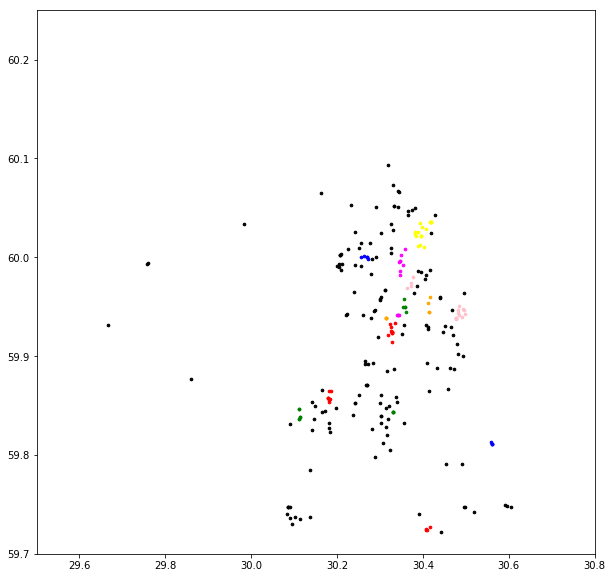

In [13]:
fig, ax = plt.subplots(figsize=(10,10))
for i, lab in enumerate(set(labels)):
    labeled = coords[labels==lab]
    plt.scatter(labeled[:, 0], labeled[:, 1], s=7, c=colors[lab if lab==-1 else lab%len(colors)])
plt.xlim(29.5, 30.8)
plt.ylim(59.7, 60.25)

## Self implementation

In [16]:
from models.cdbscan import ContinuosDBSCAN, Event
import time
to_timestamp = lambda strdate: time.mktime(time.strptime(str(strdate), '%Y-%m-%d %H:%M:%S'))

In [17]:
times = list(map(to_timestamp, subdf.index.tolist()))
events = list(map(lambda i: Event(coords[i][0], coords[i][1], times[i]), list(range(len(times)))))

model = ContinuosDBSCAN(0.01, min_samples=4, continuos_time=60*60)
labels = np.array(model.fit(events))
print(len(set(labels))-1, 'clusters found')

16 clusters found


(59.7, 60.1)

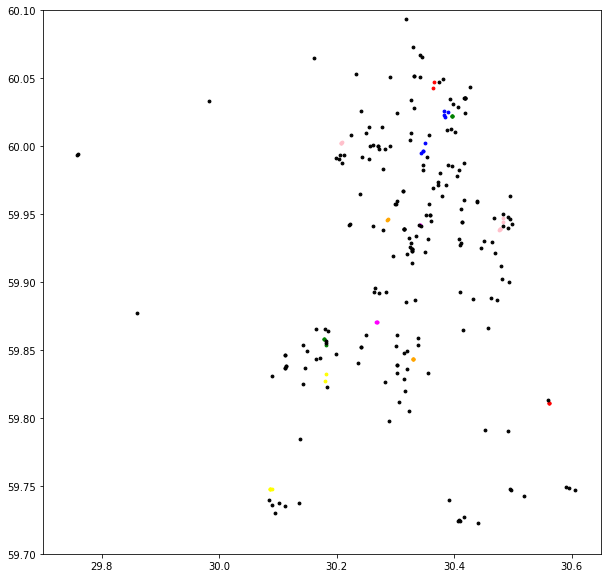

In [18]:
fig, ax = plt.subplots(figsize=(10,10))
for lab in set(labels):
    labeled = coords[labels==lab]
    plt.scatter(labeled[:, 0], labeled[:, 1], s=8, c='black' if lab==-1 else colors[lab%len(colors)])
plt.xlim(29.7, 30.65)
plt.ylim(59.7, 60.1)